In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

np.random.seed(12689)  # chosen by keyboard-mashing

%matplotlib inline

## Setup

In [2]:
n = 10  # number of neurons
h, w = (5, 5) # size of image patch
px = h*w # number of pixels
A = np.random.randn(px, n)  # projective fields

# Prior over x
cov_p = np.eye(n) * 1.
mu_p = np.zeros((n,))

# Data-generating process
cov_x = np.eye(px) * 1.

# Data-generating process
cov_eb = np.eye(px) * .1

def sigmoid(z):
    return 1/(1+np.exp(-z))


# Experimenter model: template function and noise
def T(s):
    # Generate oriented grating in a circular mask
    xx, yy = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
    rot_x = xx*np.cos(np.pi*s) + yy*np.sin(np.pi*s)
    rr = np.sqrt(xx*xx + yy*yy)
    mask = sigmoid(.75 - rr)
    return mask * np.cos(rot_x * np.pi)


def randpix(cov):
    chol = np.linalg.cholesky(cov)
    return chol @ np.random.randn(px)

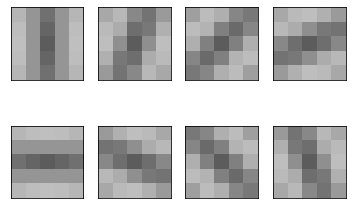

In [3]:
vrange = 1 + 2*np.sqrt(cov_eb[0,0])
T_examples = [T(s) for s in np.linspace(0, 1, 9)]
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(T_examples[i], cmap='Greys', vmin=-vrange, vmax=vrange)
    plt.xticks([]); plt.yticks([])
plt.savefig('T_gratings.svg')
plt.show()

## Decoder functions

In [4]:
def sample_posterior_x(im, n_samples=1):
    cov_prime = np.linalg.inv(np.linalg.inv(cov_p) + A.T @ np.linalg.solve(cov_x, A))
    mu_prime = cov_prime @ (np.linalg.solve(cov_p, mu_p) + A.T @ np.linalg.solve(cov_x, im))
    chol_cov_prime = np.linalg.cholesky(cov_prime)
    return mu_prime[None, :] + np.random.randn(n_samples, n) @ chol_cov_prime.T


def ppc(s, t):
    Ts = T(s).ravel() # T(s) as a vector
    inv_cov_eb = np.linalg.inv(cov_eb)
    inv_cov_x = np.linalg.inv(cov_x)
    cov_prime = np.linalg.inv(np.linalg.inv(cov_p) + A.T @ inv_cov_x @ A)
    mu_prime_prime = cov_prime @ (np.linalg.solve(cov_p, mu_p) + A.T @ inv_cov_x @ Ts)
    #     print("mu_prime_prime", mu_prime_prime.shape, mu_prime_prime)
    cov_prime_prime = cov_prime/t + cov_prime @ A.T @ inv_cov_x @ cov_eb @ inv_cov_x @ A @ cov_prime
    #     print("cov_prime_prime", cov_prime_prime.shape, cov_prime_prime)
    log_g = -0.5 * mu_prime_prime[None, :] @ np.linalg.solve(cov_prime_prime, mu_prime_prime[:, None])
    #     print("log_g", log_g.shape, log_g)
    h = np.linalg.solve(cov_prime_prime, cov_prime) @ A.T @ np.linalg.solve(cov_x, Ts)
    #     print("h", h.shape, h)
    return log_g, h.squeeze()


def log_post_s(s_grid, x_samples):
    t = len(x_samples)
    x_bar = np.mean(x_samples, axis=0)
    lps = np.zeros(s_grid.shape)
    for i, s in enumerate(s_grid):
        log_g, h = ppc(s, t)
        lps[i] = log_g + np.sum(h * x_bar)
    return lps


def sabya_ppc(s, t):
    Ts = T(s).ravel() # T(s) as a vector
    inv_cov_eb = np.linalg.inv(cov_eb)
    inv_cov_x = np.linalg.inv(cov_x)
    inv_cov_prime = np.linalg.inv(cov_p) + A.T @ inv_cov_x @ A
    B = np.linalg.solve(inv_cov_prime, A.T) @ inv_cov_x
    inv_cov_1 = t * inv_cov_prime
    inv_cov_2 = B.T @ inv_cov_1 @ B
    inv_cov_3 = inv_cov_2 + inv_cov_eb
    log_g = -1/2 * Ts[None, :] @ inv_cov_eb @ Ts[:, None] \
                + 1/2 * Ts[None, :] @ inv_cov_eb @ np.linalg.solve(inv_cov_3, inv_cov_eb) @ Ts[:, None] \
                - t * Ts[None, :] @ inv_cov_eb @ np.linalg.solve(inv_cov_3, B.T) @ np.linalg.solve(cov_p, mu_p)
    h = Ts[None, :] @ inv_cov_eb @ np.linalg.solve(inv_cov_3, B.T) @ inv_cov_1
    return log_g, h.squeeze()

    
def sabya_log_post_s(s_grid, x_samples):
    x_bar = np.mean(x_samples, axis=0)
    lps = np.zeros(s_grid.shape)
    for i, s in enumerate(s_grid):
        log_g, h = sabya_ppc(s, t)
        lps[i] = log_g + np.sum(h * x_bar)
    return lps


def log2prob(log_p):
    p = np.exp(log_p - np.max(log_p))
    return p / np.sum(p)


def log_prob_ideal_obesrver(s_grid, im, eps=0.):
    lps = np.zeros(s_grid.shape)
    im = np.reshape(im, (px, 1))
    for i, s in enumerate(s_grid):
        Ts = T(s).ravel()[:,None]
        lps[i] = -0.5*(Ts - im).T @ np.linalg.solve(cov_eb + eps*np.eye(px), (Ts - im))
    return lps

## Run example

In [5]:
true_s = np.random.rand()
im = T(true_s).ravel() + randpix(cov_eb)
decode_t = [1, 5, 10]
n_samples = max(decode_t)
x_samples = sample_posterior_x(im, n_samples)
ms_per_sample = 20

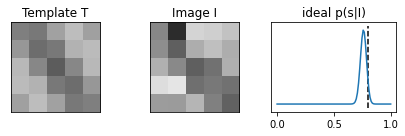

In [6]:
s_grid = np.linspace(0, 1, 100)
log_post_ideal = log_prob_ideal_obesrver(s_grid, im)

plt.figure(figsize=(6,2))
plt.subplot(1,3,1)
plt.imshow(T(true_s), cmap='Greys', vmin=-vrange, vmax=+vrange)
plt.xticks([]); plt.yticks([])
plt.title('Template T')
plt.subplot(1,3,2)
plt.imshow(im.reshape(h,w), cmap='Greys', vmin=-vrange, vmax=+vrange)
plt.xticks([]); plt.yticks([])
plt.title('Image I')
plt.subplot(1,3,3)
plt.plot(s_grid, log2prob(log_post_ideal))
plt.vlines([true_s], *plt.ylim(), linestyle='--', color='k')
plt.yticks([])
plt.title('ideal p(s|I)')
plt.gcf().tight_layout()
plt.savefig(f'T_and_I_{h}x{w}.svg')
plt.show()

### Plot samples

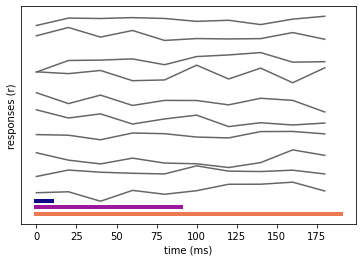

In [7]:
spacing = 1.
for i, t in enumerate(decode_t):
    plt.plot([0, (t-.5)*ms_per_sample], [-(i+1)*spacing/3, -(i+1)*spacing/3], color=cm.plasma(i/len(decode_t)), linewidth=4)
plt.plot(ms_per_sample*np.arange(n_samples), x_samples + np.arange(n)*spacing, 
         color=(.4,.4,.4))
plt.xlabel('time (ms)')
plt.ylabel('responses (r)')
plt.yticks([])
plt.savefig('responses.svg')
plt.show()

### Decode from samples

In [8]:
log_post = {}
sabya_log_post = {}
for t in decode_t:
    log_post[t] = log_post_s(s_grid, x_samples[:t, :])
    sabya_log_post[t] = sabya_log_post_s(s_grid, x_samples[:t, :])

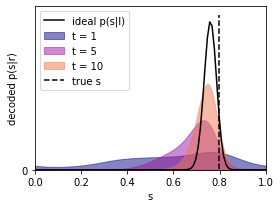

In [9]:
plt.figure(figsize=(4,3))

# plt.subplot(1,2,1)
for i, (t, lps) in enumerate(log_post.items()):
    plt.fill_between(s_grid, log2prob(lps), label=f't = {t}', color=cm.plasma(i/len(decode_t)), alpha=.5)
plt.plot(s_grid, log2prob(log_post_ideal), '-k', label='ideal p(s|I)')
plt.vlines([true_s], *plt.ylim(), linestyle='--', color='k', label='true s')
plt.xlabel('s')
plt.ylabel('decoded p(s|r)')
plt.yticks([0])
plt.legend(loc='best')
plt.xlim([0,1])
plt.ylim([0,None])

# plt.subplot(1,2,2)
# for t, lps in sabya_log_post.items():
#     plt.fill_between(s_grid, log2prob(lps), color=cm.tab10(t/max(log_post.keys())), alpha=.5)
# plt.plot(s_grid, log2prob(log_post_ideal), '-k')
# plt.vlines([true_s], *plt.ylim(), linestyle='--', color='k')
# plt.xlabel('s')
# plt.ylabel('decoded p(s|r)')
# plt.title('Sabya')
# plt.yticks([])
plt.gcf().tight_layout()
plt.savefig('ppc_s_given_x.svg')
plt.show()